In [1]:
# !pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# stock_data = pd.read_csv('acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
# stock_data

In [2]:
stock_data = pd.read_csv('../data/external/AMZN.csv')

stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
stock_data = stock_data.set_index(['Date'])
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-23,100.430000,101.059998,97.620003,98.709999,98.709999,57559300
2023-03-24,98.070000,98.300003,96.400002,98.129997,98.129997,56095400
2023-03-27,99.070000,99.339996,97.080002,98.040001,98.040001,46721300
2023-03-28,98.110001,98.440002,96.290001,97.239998,97.239998,38720100
2023-03-29,98.690002,100.419998,98.559998,100.250000,100.250000,49783300


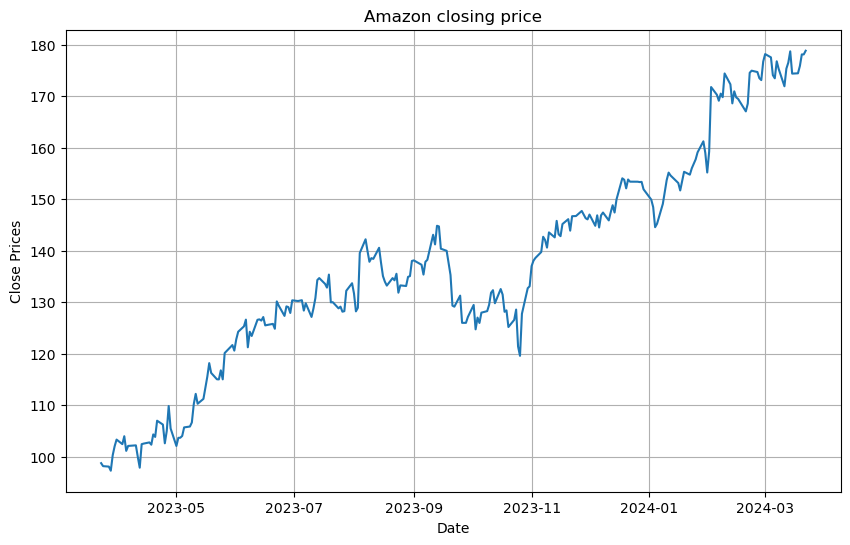

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Amazon closing price')
plt.show()

<Axes: ylabel='Density'>

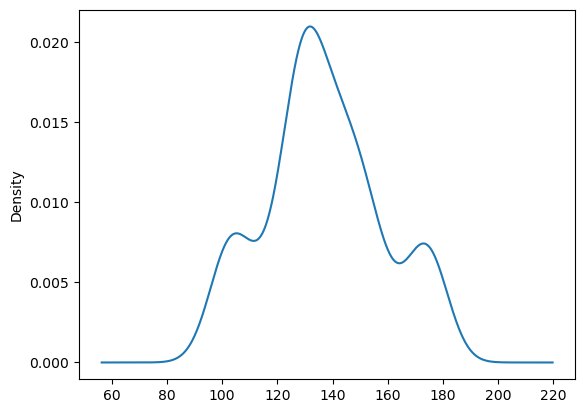

In [4]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

In [5]:
df_close.head()

Date
2023-03-23     98.709999
2023-03-24     98.129997
2023-03-27     98.040001
2023-03-28     97.239998
2023-03-29    100.250000
Name: Close, dtype: float64

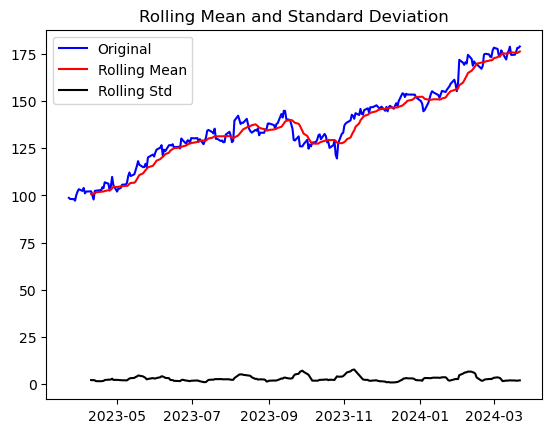

Results of dickey fuller test
Test Statistics                 -0.585863
p-value                          0.874144
No. of lags used                 2.000000
Number of observations used    249.000000
critical value (1%)             -3.456888
critical value (5%)             -2.873219
critical value (10%)            -2.572994
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

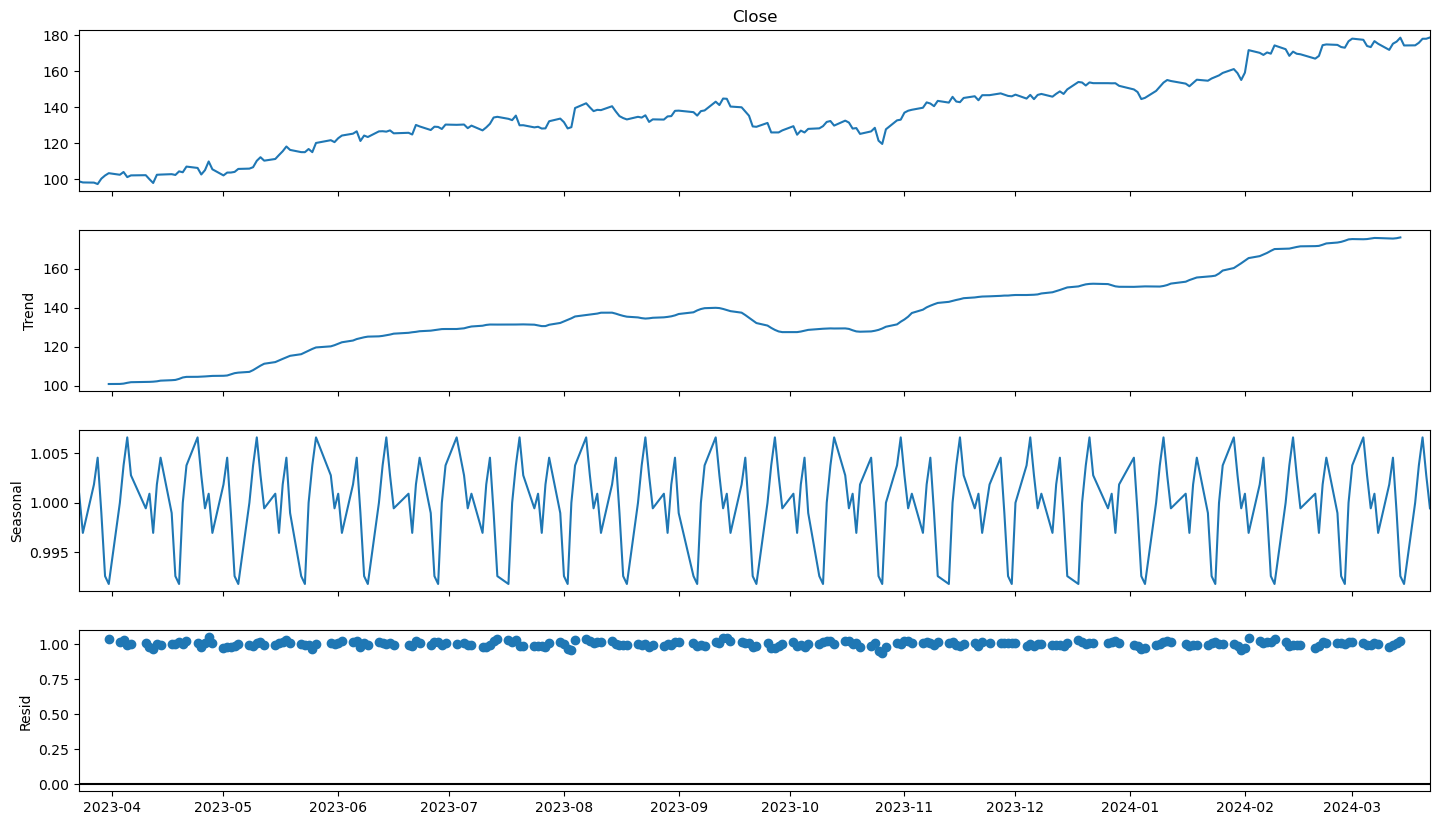

In [7]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


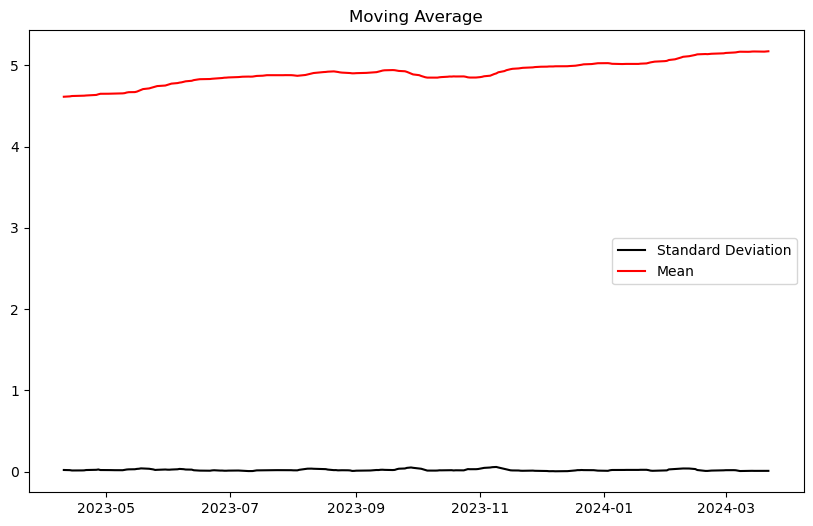

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

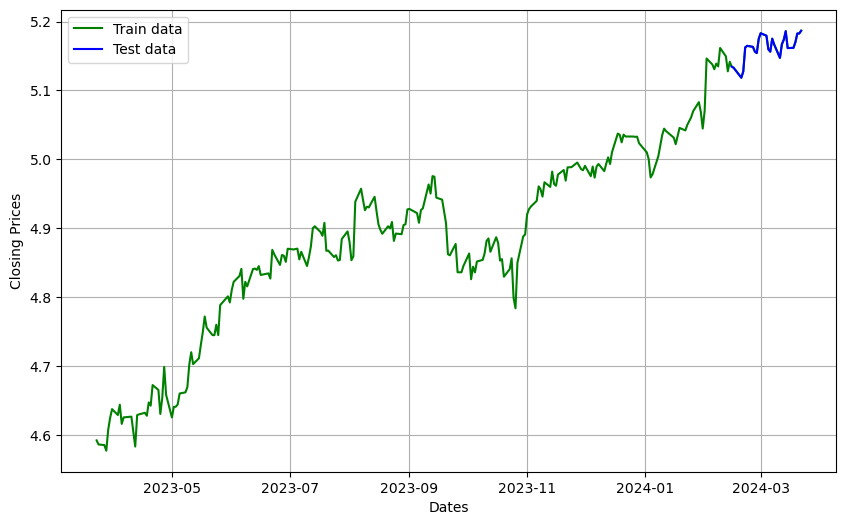

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1117.610, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1116.118, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1116.446, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1115.811, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1118.200, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1121.023, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1122.940, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1121.047, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1119.024, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1119.062, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.603 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  223
Model:               SARIMAX(2, 1, 0)   Log Likeliho

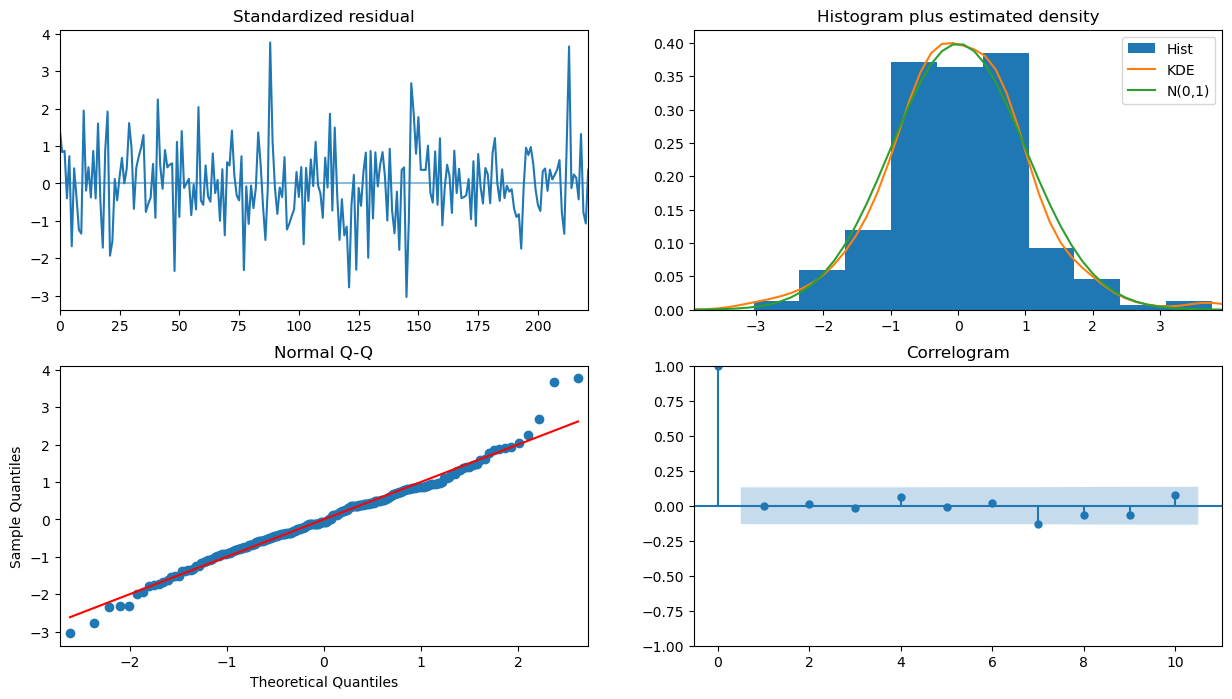

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(2,1,0))
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 562.531
Date:                Mon, 25 Mar 2024   AIC                          -1119.062
Time:                        14:10:34   BIC                          -1108.854
Sample:                             0   HQIC                         -1114.941
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0375      0.064     -0.584      0.559      -0.163       0.088
ar.L2         -0.1778      0.065     -2.741      0.006      -0.305      -0.051
sigma2         0.0004   2.94e-05     12.517      0.0

C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
test_data

Date
2024-02-15    5.134621
2024-02-16    5.132912
2024-02-20    5.118473
2024-02-21    5.127470
2024-02-22    5.162383
2024-02-23    5.164729
2024-02-26    5.163242
2024-02-27    5.156408
2024-02-28    5.154216
2024-02-29    5.174793
2024-03-01    5.183019
2024-03-04    5.179421
2024-03-05    5.159745
2024-03-06    5.156235
2024-03-07    5.175132
2024-03-08    5.166784
2024-03-11    5.147262
2024-03-12    5.167012
2024-03-13    5.173661
2024-03-14    5.185988
2024-03-15    5.161466
2024-03-18    5.161810
2024-03-19    5.169916
2024-03-20    5.182626
2024-03-21    5.182626
2024-03-22    5.186659
Name: Close, dtype: float64

<Axes: xlabel='Date'>

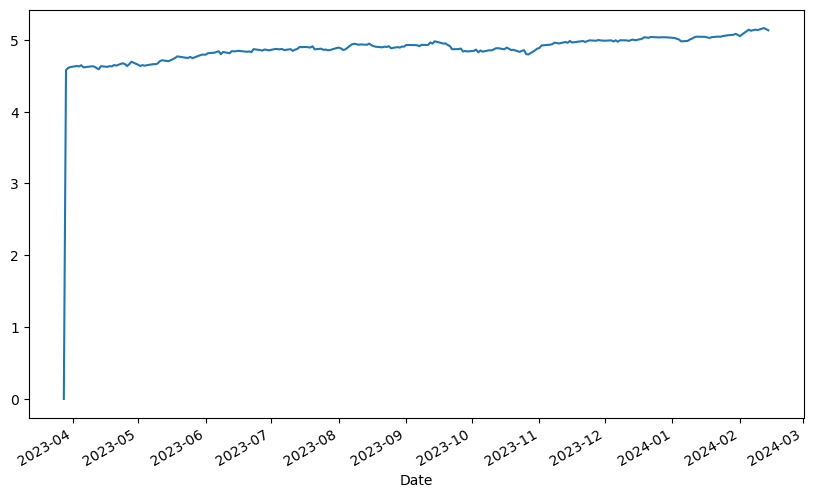

In [14]:
prediction = fitted.predict()
prediction.plot()

In [15]:
df_test_data_orig = np.exp(test_data)
df_test_data_orig

Date
2024-02-15    169.800003
2024-02-16    169.509995
2024-02-20    167.080002
2024-02-21    168.589996
2024-02-22    174.580002
2024-02-23    174.990005
2024-02-26    174.729996
2024-02-27    173.539993
2024-02-28    173.160004
2024-02-29    176.759995
2024-03-01    178.220001
2024-03-04    177.580002
2024-03-05    174.119995
2024-03-06    173.509995
2024-03-07    176.820007
2024-03-08    175.350006
2024-03-11    171.960007
2024-03-12    175.389999
2024-03-13    176.559998
2024-03-14    178.750000
2024-03-15    174.419998
2024-03-18    174.479996
2024-03-19    175.899994
2024-03-20    178.149994
2024-03-21    178.149994
2024-03-22    178.869995
Name: Close, dtype: float64